In [1]:
from transformers import GPT2LMHeadModel
import matplotlib.pyplot as plt

/home/saandeepaath-admin/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_hf = GPT2LMHeadModel.from_pretrained('gpt2')
sd_hf = model_hf.state_dict()

In [3]:
for k, v in sd_hf.items():

  print(f"{k}: {v.shape}")

transformer.wte.weight: torch.Size([50257, 768])
transformer.wpe.weight: torch.Size([1024, 768])
transformer.h.0.ln_1.weight: torch.Size([768])
transformer.h.0.ln_1.bias: torch.Size([768])
transformer.h.0.attn.c_attn.weight: torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias: torch.Size([2304])
transformer.h.0.attn.c_proj.weight: torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias: torch.Size([768])
transformer.h.0.ln_2.weight: torch.Size([768])
transformer.h.0.ln_2.bias: torch.Size([768])
transformer.h.0.mlp.c_fc.weight: torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias: torch.Size([3072])
transformer.h.0.mlp.c_proj.weight: torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias: torch.Size([768])
transformer.h.1.ln_1.weight: torch.Size([768])
transformer.h.1.ln_1.bias: torch.Size([768])
transformer.h.1.attn.c_attn.weight: torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias: torch.Size([2304])
transformer.h.1.attn.c_proj.weight: torch.Size([768, 768])
transformer.h.

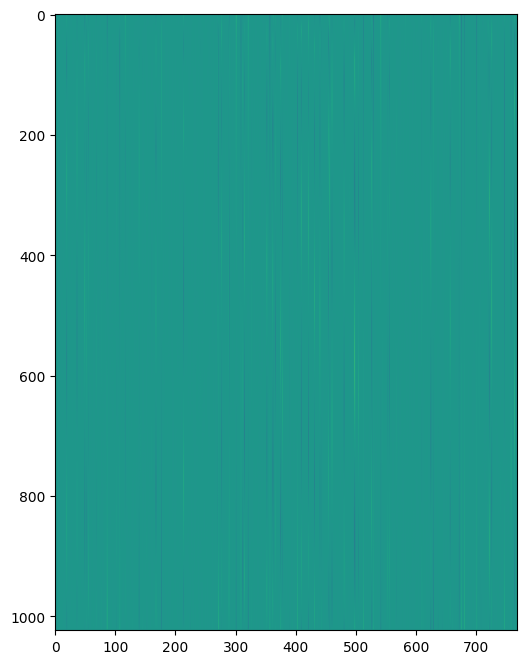

In [4]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.imshow(sd_hf['transformer.wpe.weight'])

In [5]:
pe = sd_hf['transformer.wpe.weight']
pe.shape

torch.Size([1024, 768])

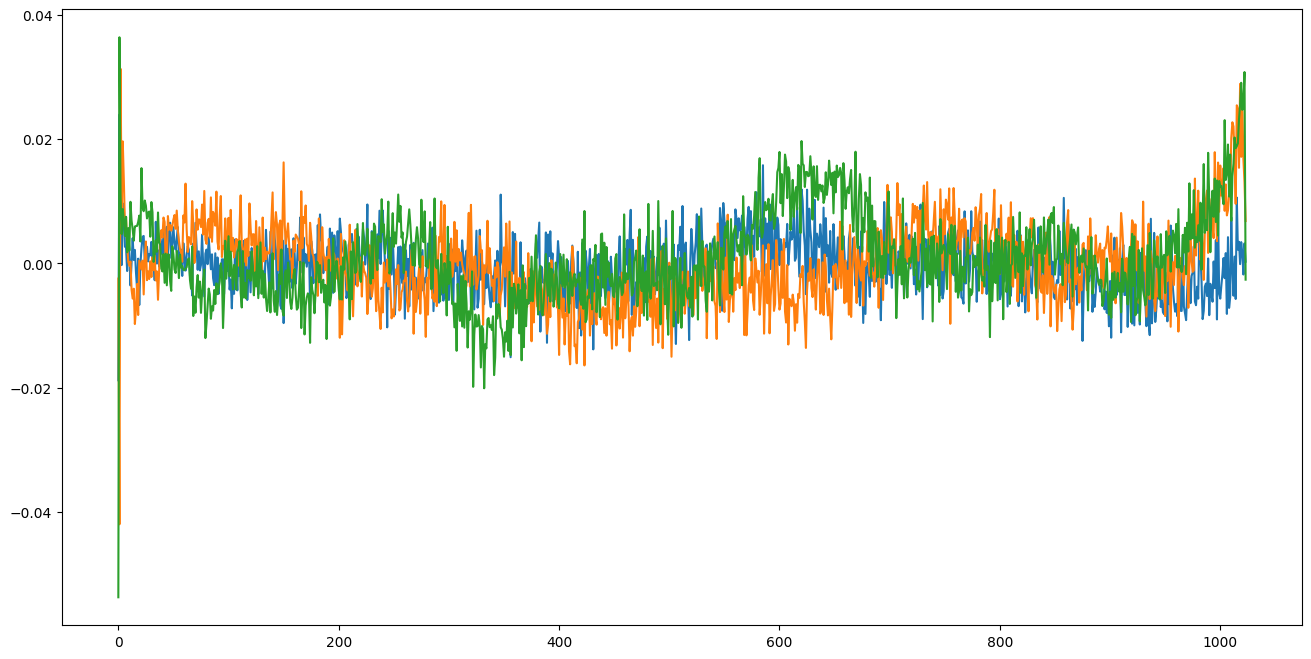

In [6]:
plt.plot(pe[:, 0])
plt.plot(pe[:, 10])
plt.plot(pe[:, 200])

In [7]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello I am a PhD student and", max_length=30, num_return_sequences=5)

/home/saandeepaath-admin/anaconda3/envs/torch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-

[{'generated_text': 'Hello I am a PhD student and my thesis concerns some of the data about men across the United States. There is no good definition under those terms,'},
 {'generated_text': 'Hello I am a PhD student and this is my first time and I love studying chemistry. I also love studying molecular biology and I love to work with'},
 {'generated_text': "Hello I am a PhD student and I am very fascinated about the subject of bioinformatics. I'd like to provide some pointers that I can"},
 {'generated_text': 'Hello I am a PhD student and you two do really good job of making the case, you really are working very hard on the case, you know'},
 {'generated_text': 'Hello I am a PhD student and I have been studying and teaching about human consciousness and psychology at the University of Cambridge for quite a while. This semester'}]

In [8]:
import torch
import tiktoken
from torch.nn import functional as F

num_sequences = 5
max_length=30
device = torch.device('cuda')

enc = tiktoken.get_encoding('gpt2')
tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11]
tokens = torch.tensor(tokens, dtype=torch.long).to(device)
x = tokens.view(1, -1).repeat(num_sequences, 1)
print(x.shape)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to(device)


# generation
while x.size(1) < max_length:
    with torch.no_grad():
        logits = model(x)[0]
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)

        top_k_probs, top_k_ind = torch.topk(probs, 50, dim=-1)

        ix = torch.multinomial(top_k_probs, 1)
        xcol = torch.gather(top_k_ind, dim=-1, index=ix)
        x = torch.cat((x, xcol), dim=1)


for i in range(num_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)
print("Dint crash :")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


torch.Size([5, 8])
> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some
Dint crash :


In [9]:
with open("../data/input.txt", "r", encoding='utf-8') as f:
  text = f.read()

len(text)

1115394

In [10]:
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(text)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


In [11]:
x = torch.tensor(tokens[:25])
x.shape

torch.Size([25])

In [12]:
bx = x[:-1].view(4, 6)
by = x[1:].view(4, 6)
bx, by

(tensor([[ 5962, 22307,    25,   198,  8421,   356],
         [ 5120,   597,  2252,    11,  3285,   502],
         [ 2740,    13,   198,   198,  3237,    25],
         [  198,  5248,   461,    11,  2740,    13]]),
 tensor([[22307,    25,   198,  8421,   356,  5120],
         [  597,  2252,    11,  3285,   502,  2740],
         [   13,   198,   198,  3237,    25,   198],
         [ 5248,   461,    11,  2740,    13,   198]]))

In [13]:
a = torch.zeros(768)

for i in range(50):
  a = a + (torch.randn(768) * 50 **-0.5)

a.std()

tensor(0.9923)

## **Grad Accumulator**

In [23]:
from torch import nn 
from torch.nn import functional  as F
net = nn.Sequential(
  nn.Linear(16, 32),
  nn.GELU(), 
  nn.Linear(32, 1)
)



In [24]:
x = torch.randn((4, 16))
y = torch.randn((4, 1))


In [25]:
y_hat = net(x)
loss = F.mse_loss(y, y_hat)
loss.backward()

print(net[0].weight.grad[0])

for i in range(4):
  pass

tensor([ 0.1841, -0.0278, -0.2151,  0.0198,  0.0094,  0.0643, -0.0845, -0.0034,
        -0.0012, -0.0510,  0.0521, -0.0352, -0.0338, -0.0499, -0.0374,  0.0171])


In [27]:
net.zero_grad()
for i in range(4):
  y_hat = net(x[i])
  loss = F.mse_loss(y[i], y_hat)
  loss /= 4.
  loss.backward()
print(net[0].weight.grad[0])


tensor([ 0.1841, -0.0278, -0.2151,  0.0198,  0.0094,  0.0643, -0.0845, -0.0034,
        -0.0012, -0.0510,  0.0521, -0.0352, -0.0338, -0.0499, -0.0374,  0.0171])
